# <center> PROCESAMIENTO DIGITAL DE SEÑALES DE AUDIO</center>
## <center> Procesamiento con STFT - 2024</center>    
## <center> Ejemplo separación.</center>
  

### Descripción

Este ejercicio busca ser mostrar una aplicación utilizando procesamiento con la **STFT**.

La tarea planteada consiste en tomar una mezcla de dos audios, identificar dónde están las componentes tiempo frecuencia de una de ellas.
Luego generar una máscara en el dominio tiempo frecuencia y separar la mezcla.


In [14]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile

import IPython.display as ipd

#open both files
fs, x1 = wavfile.read('pop1_short_32k.wav')
fs, x2 = wavfile.read('sparrow_short_32_k.wav')



In [15]:
ipd.Audio(x1, rate=fs)

In [16]:
ipd.Audio(x2, rate=fs)

In [17]:
#mix them by summing them
max_len = max([len(x1),len(x2)])

x_mix = np.zeros(max_len)
x_mix[0:len(x1)] = x1/2
start_pos = int((len(x1)-len(x2))/2)
x_mix[ start_pos:start_pos+len(x2)] += x2/2
x_mix = x_mix/32767.0

ipd.Audio(x_mix, rate=fs)

In [30]:
wavfile.write('mix_files.wav',fs,x_mix)

fs, x_mix = wavfile.read('mix_files.wav')


N=512;
hop = int(N/2);
window = signal.hann(N);


pos_frames = range(hop,len(x_mix)-hop,hop)

espectrograma = np.zeros([N,len(pos_frames)], dtype=complex)


for i in range(len(pos_frames)):
    frame_data = x_mix[pos_frames[i]-hop:pos_frames[i]+hop];
    espectrograma[:,i] = np.fft.fft(frame_data*window);    
    #frame_data_2 = np.fft.ifft(espectro[:,i])
    

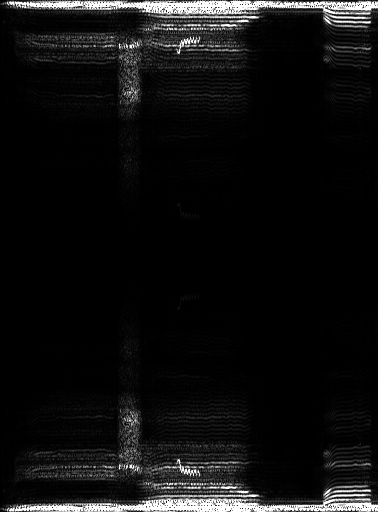

In [31]:
im = Image.fromarray(np.abs(espectrograma)*50.0)
im = im.convert("L")
im.save('mix_spectrum.png')
from IPython.display import display
from PIL import Image

display(im)

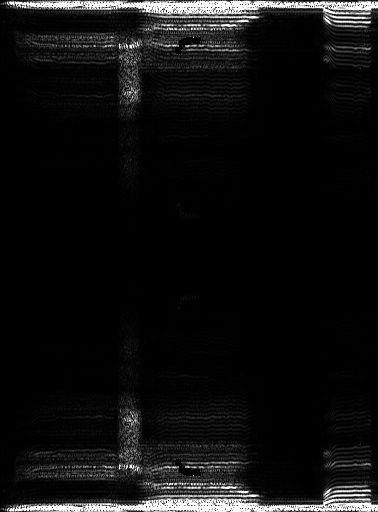

In [32]:
from PIL import Image
from PIL import PngImagePlugin

mask = 1.0-(np.array(Image.open('mask.png'))[:,:,0])/255.0
mask = (np.array(Image.open('mask.png'))[:,:,0])/255.0



#mask the spectrogram
espectrograma = np.multiply(espectrograma,mask)

#force the spectrogram to be symmetric conjugate (real in time)
for i in range(len(pos_frames)):
    espectrograma[1:int(N/2),i] = np.flip(np.conjugate(espectrograma[int(N/2)+1:,i]))


im = Image.fromarray(np.abs(espectrograma)*50.0)
im = im.convert("L")
im.save('masked_spectrum.png')

display(im)




In [33]:
#overlap add
xout = np.zeros(len(x_mix))
for i in range(len(pos_frames)):
    frame_fft = espectrograma[:,i]
    xout[pos_frames[i]-hop:pos_frames[i]+hop] += np.real(np.fft.ifft(frame_fft))

xout = (xout*32767.0).astype(np.int16)


wavfile.write('sep_python.wav',fs,xout)

ipd.Audio(xout, rate=fs)